In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pydot
import os
from IPython.display import SVG, display
from pydrake.all import (
    AddMultibodyPlantSceneGraph,
    DiagramBuilder,
    InverseDynamicsController,
    LeafSystem,
    MeshcatVisualizer,
    MultibodyPlant,
    Parser,
    Simulator,
    StartMeshcat
    RotationMatrix,
    StateInterpolatorWithDiscreteDerivative,
    ConstantVectorSource,
    DiagramBuilder,
    MeshcatVisualizer,
    MeshcatVisualizerParams,
    MultibodyPlant,
    Parser,
    PiecewisePolynomial,
    PiecewiseQuaternionSlerp,
    RigidTransform,
    RollPitchYaw,
    RotationMatrix,
    Simulator,
    Solve,
    StartMeshcat,
    TrajectorySource,
)
from manipulation.station import MakeHardwareStation, load_scenario
from manipulation.scenarios import AddMultibodyTriad, MakeManipulationStation
from manipulation.meshcat_utils import AddMeshcatTriad
from pydrake.multibody import inverse_kinematics
import matplotlib.pyplot as plt
import copy
import time
from collections import Counter

In [3]:
import scene
import AllegroWrapper

In [4]:
meshcat = None
brick_location = None

In [5]:
meshcat, station, simulator, context, brick_location = scene.init_scenario(brick_location=brick_location, meshcat=meshcat)
allegro = AllegroWrapper.AllegroHand(station, context)
simulator.set_target_realtime_rate(1.0)
x0 = allegro.get_state()

INFO:drake:Meshcat listening for connections at http://localhost:7001


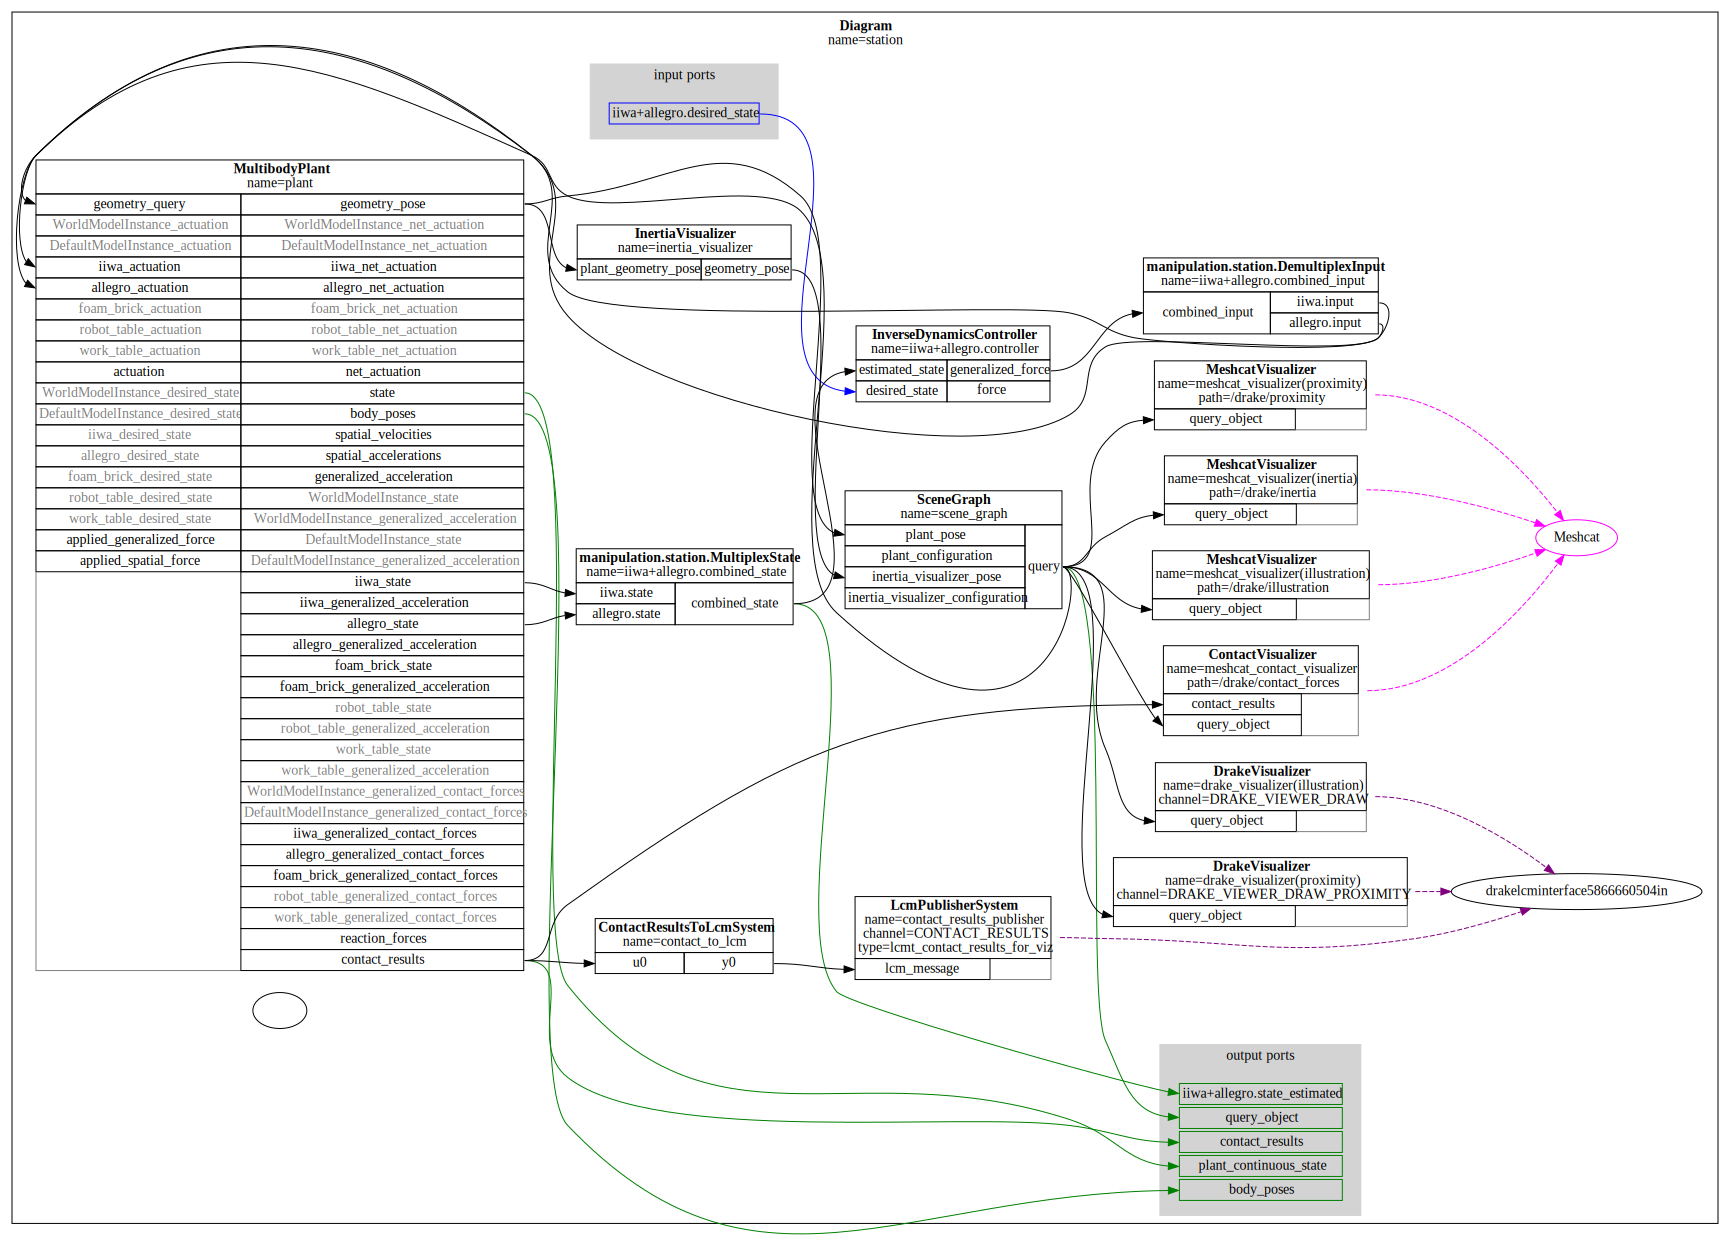

In [6]:
display(
    SVG(
        pydot.graph_from_dot_data(station.GetGraphvizString(max_depth=1))[
            0
        ].create_svg()
    )
)

In [7]:
def reset_arm():
    station.GetInputPort("iiwa+allegro.desired_state").FixValue(context, x0)
    simulator.AdvanceTo(context.get_time() + 1)

In [8]:
def normalize(v):
    return v / np.sum(v)

In [9]:
def get_table_contact(X_robot_W, final_height = -0.2, num_knot_points=10):
    """
    Moves the arm down until it comes in contact with the table
    """
    final_rotation = X_robot_W.rotation()
    initial_position = X_robot_W.translation()
    final_position = copy.deepcopy(initial_position)
    final_position[2] = final_height
    # final_position = [0.5, 0, 0]
    t_list = np.arange(num_knot_points)
    positions = np.zeros((num_knot_points, 3))
    for i in range(3):
        positions[:, i] = np.linspace(
            initial_position[i], final_position[i], num_knot_points
        )
    p_list = []
    for p in positions:
        p_list.append(RigidTransform(final_rotation, p))
    return p_list



def sample_new_target(prev_touch, p_grid, target_bias=None, xmin=0.3, xmax=0.5, ymin=-0.3, ymax=0.3, n_samples=10):
    """
        Proposes a new location to reach with the hand.
        
        Args:
            previous_targets: np.array[coords]: list of previous target locations already checked 
            target_bias: np.array: (x, y, z) location to act as a kind of bias
    """
    object_r = 0.05
    effort_ratio = 0.7
    effort_c = 2.0
    p_target_c = 2.0

    table_x_bounds = [xmin, xmax]
    table_y_bounds = [ymin, ymax]

    if len(list(p_grid.keys())) == 0:
        p_grid = {}
        for x in np.linspace(table_x_bounds[0], table_x_bounds[1], n_samples):
            for y in np.linspace(table_y_bounds[0], table_y_bounds[1], n_samples):
                p_grid[(x, y)] = 0.5

    all_p = []
    all_effort = []
    all_dist = []
    table_grid = {}
    for coord, prob in p_grid.items():
        dist = np.linalg.norm(np.array(coord) - prev_touch)
        if dist < object_r:
            p_target = 0.0
        else:
            c_dist = dist - object_r
            p_target = 1 - np.exp(-p_target_c * c_dist)
        new_p_target = prob * p_target
        if new_p_target == 0.0:
            effort_cost = 0.0
        else:
            effort_cost = np.exp(-effort_c * c_dist)
        p_grid[coord] = new_p_target
        all_effort.append(effort_cost)
        all_p.append(new_p_target)
        all_dist.append(dist)
    all_effort_norm = normalize(all_effort)
    all_p_norm = normalize(all_p)
    for i, coord in enumerate(p_grid.keys()):
        table_grid[coord] = all_p_norm[i] * (1 - effort_ratio) + all_effort_norm[i] * effort_ratio
    table_grid_norm = normalize(list(table_grid.values()))
    next_touch_idx = np.random.choice(np.arange(len(list(table_grid.keys()))), p=table_grid_norm)
    next_touch = list(p_grid.keys())[next_touch_idx]
    
    return next_touch, p_grid


def interpolate_locations(current_location, new_location, X_robot_W, interp_steps=10, arc_height=0.5):
    # NOTE: Convert positions to RigidTransforms
    """
    Linear interpolation between two 3D coordinates
    """
    coords = np.hstack([current_location, new_location])
    xs = np.linspace(current_location[0], new_location[0], interp_steps)
    ys = np.linspace(current_location[1], new_location[1], interp_steps)

    # If z-values are the same, move the arm up to avoid dragging along 
    if current_location[2] == new_location[2]:
        z0 = np.linspace(current_location[2], current_location[2] + arc_height, interp_steps // 2)
        z1 = np.linspace(current_location[2] + arc_height, new_location[2], interp_steps // 2)
        zs = np.concatenate([z0, z1])

    else:
        zs = np.linspace(current_location[2], new_location[2], interp_steps)
    
    interp_coords = np.vstack((xs, ys, zs)).T
    new_coords = np.vstack([interp_coords, new_location])

    pose_list = []
    for i in range(len(new_coords)):
        pose = RigidTransform(X_robot_W.rotation(), new_coords[i])
        pose_list.append(pose)
        
    return pose_list


def optimize_arm_movement(end_effector_poses, frame="iiwa_link_6"):
    """Convert end-effector pose list to joint position list using series of
    InverseKinematics problems. Note that q is 9-dimensional because the last 2 dimensions
    contain gripper joints, but these should not matter to the constraints.
    @param: pose_lst (python list): post_lst[i] contains keyframe X_WG at index i.
    @return: q_knots (python_list): q_knots[i] contains IK solution that will give f(q_knots[i]) \approx pose_lst[i].
    """
    q_knots = []
    plant = station.GetSubsystemByName("plant")
    world_frame = plant.world_frame()
    gripper_frame = plant.GetFrameByName(frame)

    # iiwa_initial = robot_state[:7]
    # gripper_initial = robot_state[7:30]
    iiwa_initial = np.array([0.0, 0.1, 0.0, -1.5, 0.0, 0.0, 0.0])
    gripper_initial = np.ones((23))
    q_nominal = np.concatenate((iiwa_initial, gripper_initial))

    def AddPositionConstraint(ik, p_WG_lower, p_WG_upper):
        """Add position constraint to the ik problem. Implements an inequality
        constraint where f_p(q) must lie between p_WG_lower and p_WG_upper. Can be
        translated to
        ik.prog().AddBoundingBoxConstraint(f_p(q), p_WG_lower, p_WG_upper)
        """
        ik.AddPositionConstraint(
            frameA=world_frame,
            frameB=gripper_frame,
            p_BQ=np.zeros(3),
            p_AQ_lower=p_WG_lower,
            p_AQ_upper=p_WG_upper,
        )

    for i in range(len(end_effector_poses)):
        ik = inverse_kinematics.InverseKinematics(plant)
        q_variables = ik.q()  # Get variables for MathematicalProgram
        prog = ik.prog()  # Get MathematicalProgram

        pose = end_effector_poses[i]
        AddPositionConstraint(
                    ik,
                    pose.translation(),
                    pose.translation(),
        )
    
        prog.AddQuadraticErrorCost(np.identity(len(q_variables)), q_nominal, q_variables)
        if i == 0:
            prog.SetInitialGuess(q_variables, q_nominal)
        else:
            prog.SetInitialGuess(q_variables, q_knots[i-1])

        result = Solve(prog)

        assert result.is_success()
        q_knots.append(result.GetSolution(q_variables))

    # t_list = np.arange(len(q_knots))
    # q_traj = PiecewisePolynomial.CubicShapePreserving(t_list, np.array(q_knots).T)
    return np.array(q_knots)
    

def get_contacts(station, context):
    # simulator = Simulator(station)
    # simulator.AdvanceTo(0.1)
    contacts = []
    contact = station.GetOutputPort("contact_results").Eval(context)
    num_contacts = contact.num_point_pair_contacts()
    for i in range(num_contacts):
        contacts.append(contact.point_pair_contact_info(i).contact_point())
    return np.array(contacts)


def move_arm(station, context, end_effector_poses, time_interval=0.4, frame="iiwa_link_6"):
    """
    Add logic for re-planning on contact
    """    
    trajectory = optimize_arm_movement(end_effector_poses, frame=frame)
    arm_trajectory = trajectory[:, :7]
    for state_update in arm_trajectory:
        new_State = station.GetInputPort("iiwa+allegro.desired_state").Eval(context)
        new_State[:len(state_update)] = state_update
        station.GetInputPort("iiwa+allegro.desired_state").FixValue(context, new_State)
        for i in range(100):
            simulator.AdvanceTo(context.get_time() + time_interval / 100)
            # Check for contact
            current_contact = get_contacts(station, context)
            if len(current_contact) > 0:
                obj_touched = evaluate_contact(current_contact)
                break
            else:
                obj_touched = False
    return obj_touched, current_contact


def evaluate_contact(current_contact, threshold=0.0001):
    """
    Determine if contact is likely an object or the table
    """
    # find the min difference between z values
    z_diff = np.max(current_contact[:, 2])
    # print(z_diff)
    if z_diff < threshold:
        touch = "table"
    else:
        touch = "object"
    return touch

In [10]:
reset_arm()

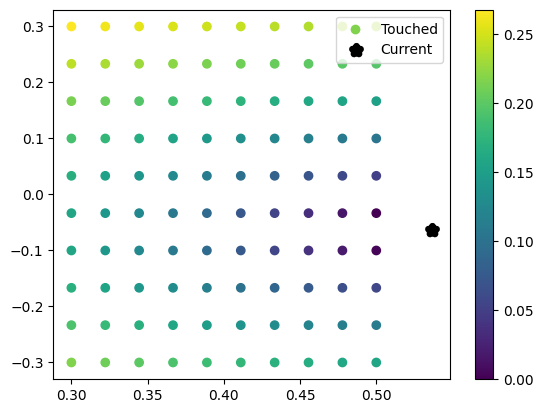

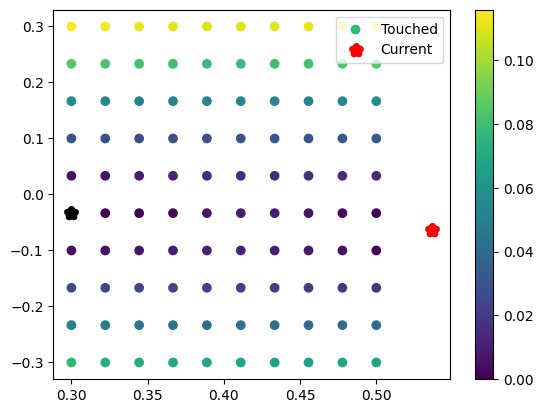

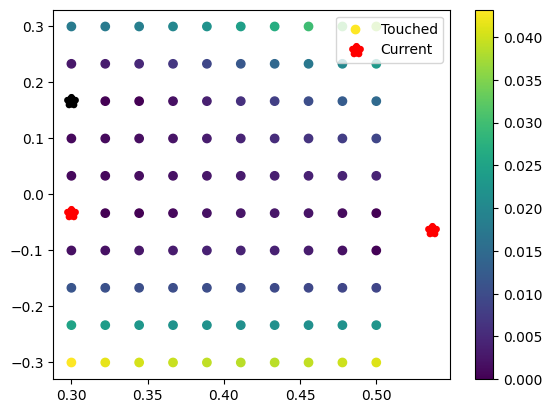

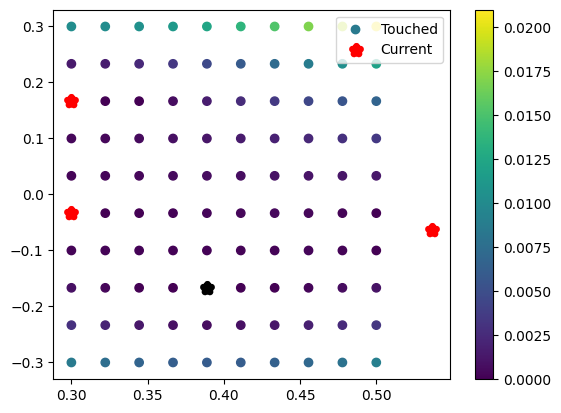

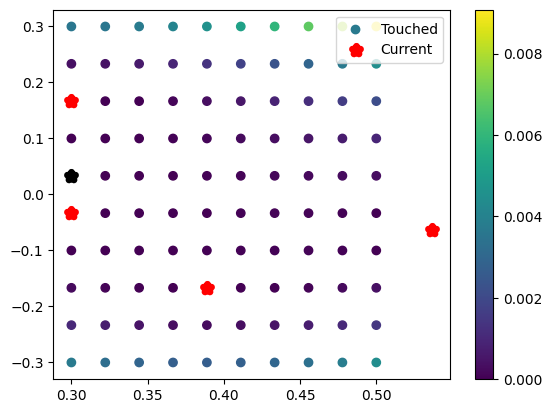

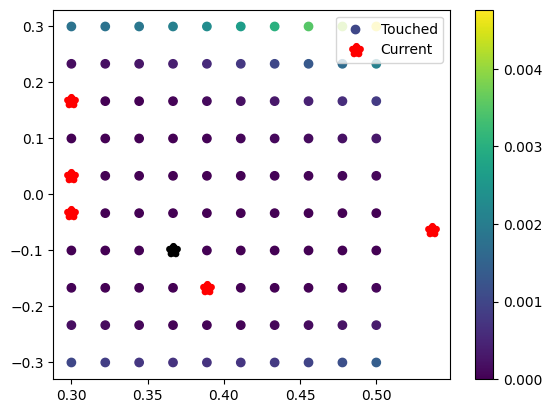

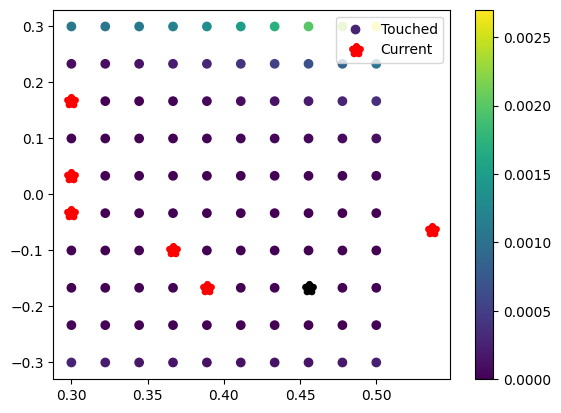

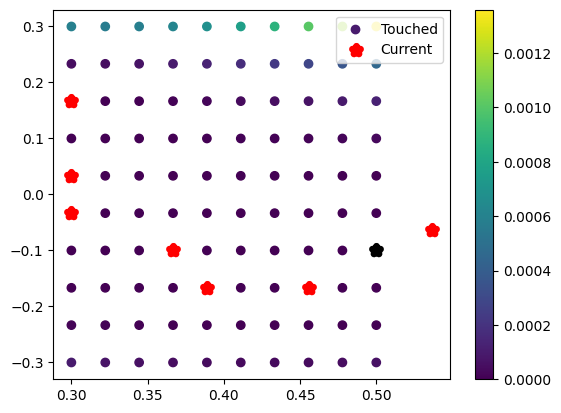

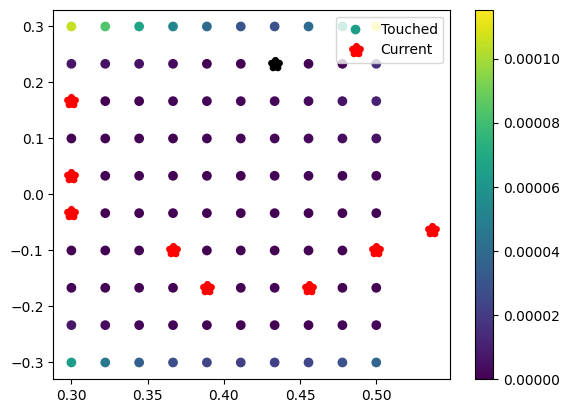

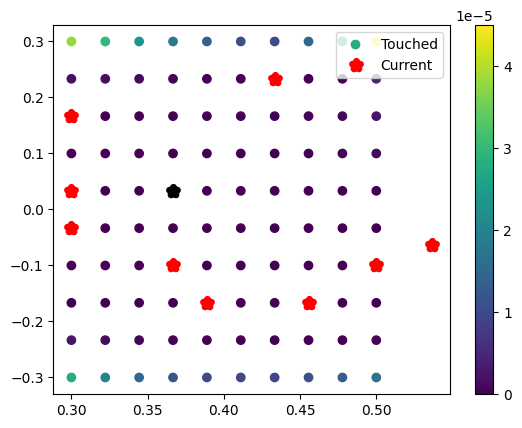

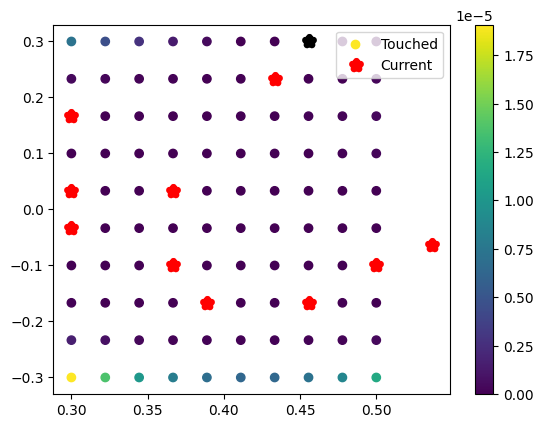

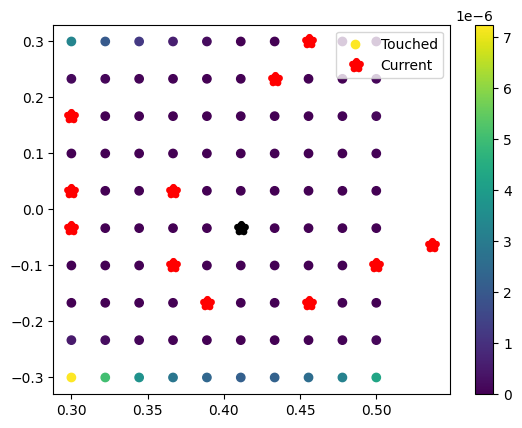

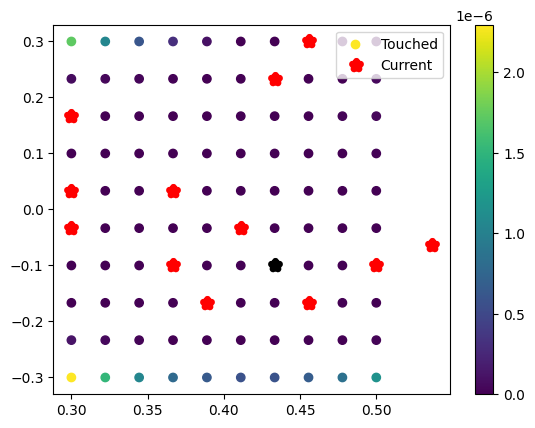

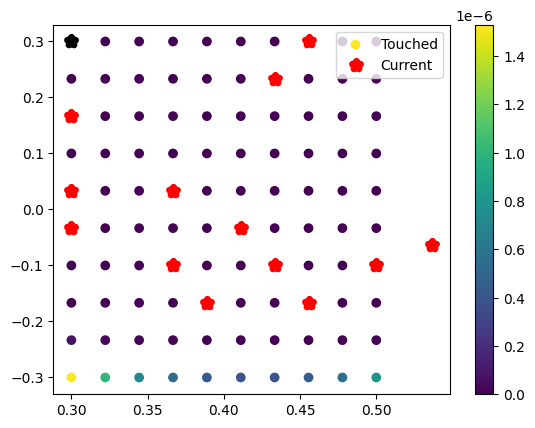

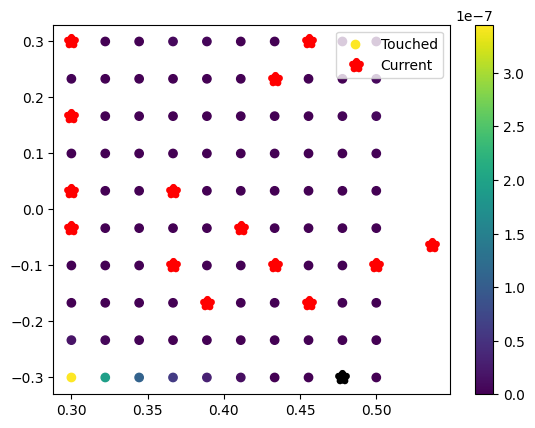

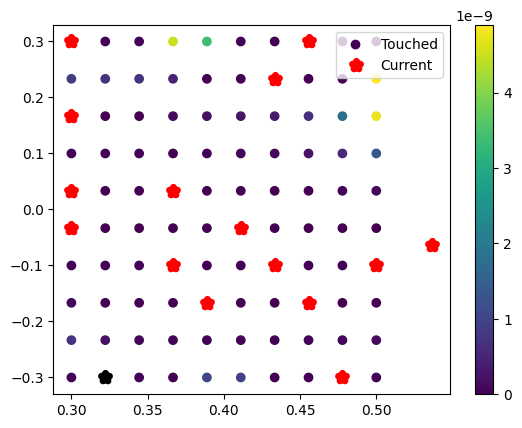

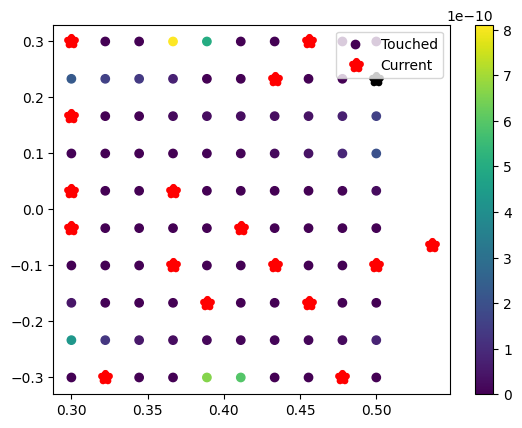

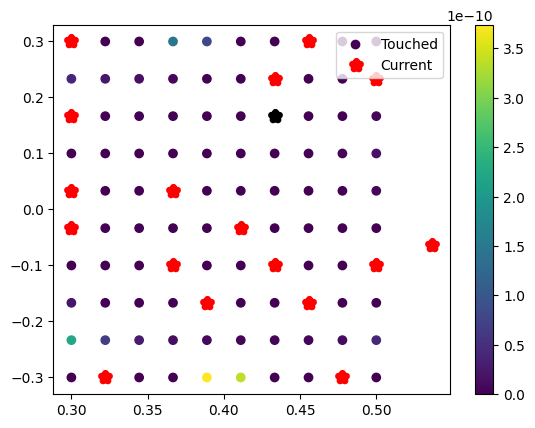

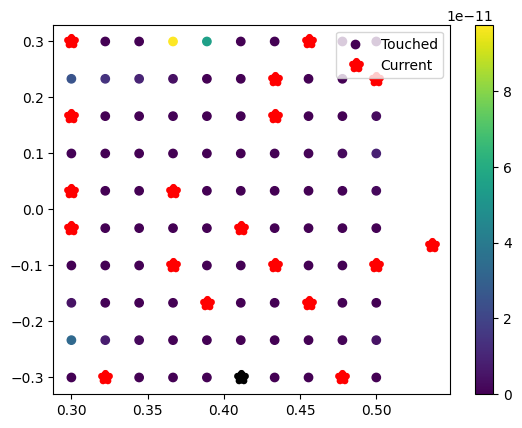

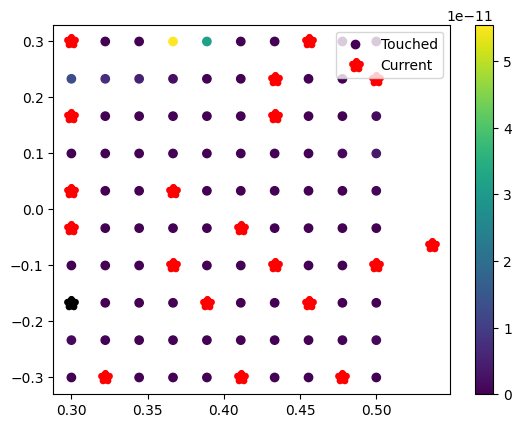

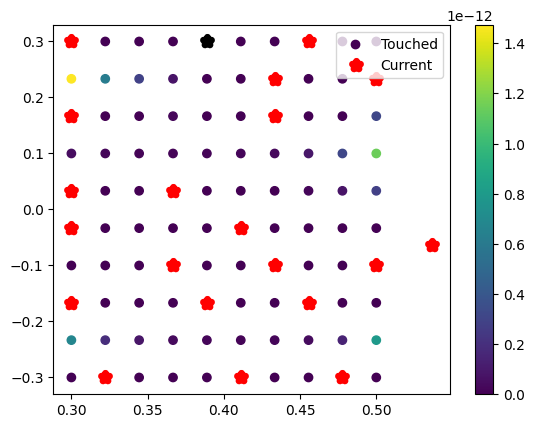

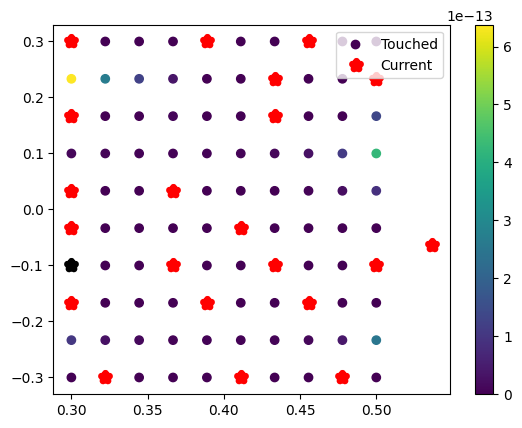

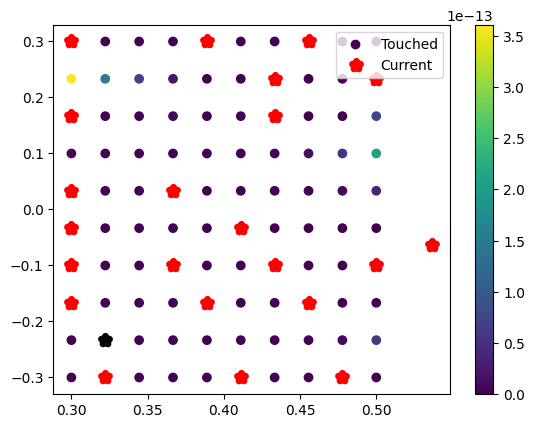

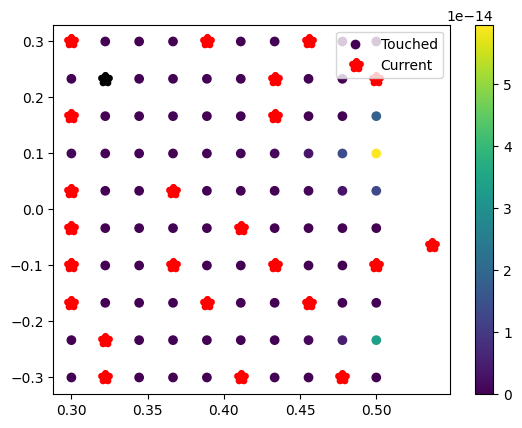

In [11]:
def run_search(station, frame = "iiwa_link_6"):
    plant = station.GetSubsystemByName("plant")
    # Get initial pose of the gripper by using default context of manip station.
    gripper = plant.GetBodyByName(frame)
    plant_context = plant.GetMyContextFromRoot(context)
    X_robot_W = plant.EvalBodyPoseInWorld(plant_context, gripper)
    table_end_effector_poses = get_table_contact(X_robot_W)
    obj_touched, new_contacts = move_arm(station, context, table_end_effector_poses)
    if obj_touched == "table":
        table_height = new_contacts[0][2]
        touched_point = new_contacts[np.random.choice(np.arange(len(new_contacts)))]
    else:
        print("Table not found")
        AssertionError()
    p_grid = {}
    all_touched_points = []
    i = 0
    while obj_touched == "table":
        if i > 30:
            break
        i += 1
        # reset_arm()
        current_touch = touched_point[:2]
        all_touched_points.append(current_touch)
        next_touch, p_grid = sample_new_target(current_touch, p_grid)
        next_point = [next_touch[0], next_touch[1], table_height]
        # print(next_point)
        end_effector_poses = interpolate_locations(touched_point, next_point, X_robot_W)
        obj_touched, new_contacts = move_arm(station, context, end_effector_poses)
        touched_point = copy.deepcopy(next_point)

        x = []
        y = []    
        z = []
        for coord, prob in p_grid.items():
            x.append(coord[0])
            y.append(coord[1])
            z.append(prob)
        plt.scatter(x, y, c=z)
        plt.colorbar()
        # show the touched point with a star
        for i, t in enumerate(all_touched_points):
            if i < len(all_touched_points) - 1:
                plt.scatter(t[0], t[1], marker="*", c="red", linewidths=5)
            else:
                plt.scatter(t[0], t[1], marker="*", c="black", linewidths=5)
        # legend the two star points
        plt.legend(["Touched", "Current"])
        plt.show()

run_search(station)

In [26]:
reset_arm()